In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:


from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np



Using TensorFlow backend.


In [0]:
img_rows = 28
img_cols = 28
channels = 1
latent_dim = 100
img_shape = (img_rows, img_cols, channels)

In [0]:
def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [0]:
def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [0]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256  

In [0]:


def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()



In [0]:
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [0]:
!mkdir -p images

In [0]:
train(epochs=4000, batch_size=32, save_interval=50)

11493376/11490434 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.847885, acc.: 40.62%] [G loss: 0.808663]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.459424, acc.: 79.69%] [G loss: 1.291082]
2 [D loss: 0.268976, acc.: 92.19%] [G loss: 1.925767]
3 [D loss: 0.249090, acc.: 90.62%] [G loss: 1.934038]
4 [D loss: 0.231978, acc.: 93.75%] [G loss: 2.503108]
5 [D loss: 0.371982, acc.: 82.81%] [G loss: 3.273436]
6 [D loss: 0.402767, acc.: 81.25%] [G loss: 3.463470]
7 [D loss: 0.498618, acc.: 75.00%] [G loss: 3.747178]
8 [D loss: 0.407986, acc.: 84.38%] [G loss: 4.106350]
9 [D loss: 0.538703, acc.: 78.12%] [G loss: 3.701798]
10 [D loss: 0.612729, acc.: 67.19%] [G loss: 2.434855]
11 [D loss: 0.380811, acc.: 82.81%] [G loss: 2.443601]
12 [D loss: 0.395607, acc.: 79.69%] [G loss: 1.636130]
13 [D loss: 0.264647, acc.: 92.19%] [G loss: 0.980777]
14 [D loss: 0.235974, acc.: 92.19%] [G loss: 0.646201]
15 [D loss: 0.204789, acc.: 90.62%] [G loss: 0.824914]
16 [D loss: 0.368419, acc.: 81.25%] [G loss: 0.960154]
17 [D loss: 0.465244, acc.: 75.00%] [G loss: 1.573814]
18 [D loss: 1.033662, acc.: 43.75%] [G loss: 2.848818]
19 [D loss: 1.17794

In [0]:
ls images

mnist_0.png     mnist_1650.png  mnist_2400.png  mnist_3100.png  mnist_3850.png
mnist_1000.png  mnist_1700.png  mnist_2450.png  mnist_3150.png  mnist_3900.png
mnist_100.png   mnist_1750.png  mnist_2500.png  mnist_3200.png  mnist_3950.png
mnist_1050.png  mnist_1800.png  mnist_250.png   mnist_3250.png  mnist_400.png
mnist_1100.png  mnist_1850.png  mnist_2550.png  mnist_3300.png  mnist_450.png
mnist_1150.png  mnist_1900.png  mnist_2600.png  mnist_3350.png  mnist_500.png
mnist_1200.png  mnist_1950.png  mnist_2650.png  mnist_3400.png  mnist_50.png
mnist_1250.png  mnist_2000.png  mnist_2700.png  mnist_3450.png  mnist_550.png
mnist_1300.png  mnist_200.png   mnist_2750.png  mnist_3500.png  mnist_600.png
mnist_1350.png  mnist_2050.png  mnist_2800.png  mnist_350.png   mnist_650.png
mnist_1400.png  mnist_2100.png  mnist_2850.png  mnist_3550.png  mnist_700.png
mnist_1450.png  mnist_2150.png  mnist_2900.png  mnist_3600.png  mnist_750.png
mnist_1500.png  mnist_2200.png  mnist_2950.png  mnist_3650.png

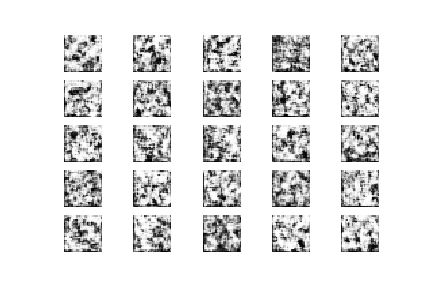

In [0]:
from IPython.display import display
from PIL import Image


path="images/mnist_0.png"
display(Image.open(path))

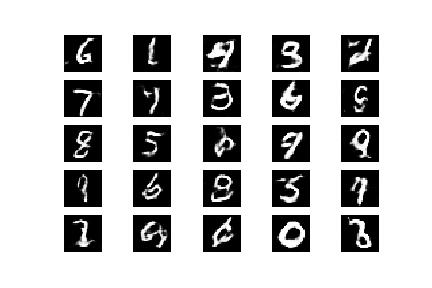

In [0]:
from IPython.display import display
from PIL import Image


path="images/mnist_3950.png"
display(Image.open(path))